In [ ]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Dropout,Activation,BatchNormalization,ReLU,add
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Input,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import CSVLogger ,EarlyStopping ,ReduceLROnPlateau

In [ ]:
DATASET_PATH = 'sample'

IMAGE_SIZE = (224,224)

NUM_CLASSES = 5

BATCH_SIZE = 256

# Epoch 數
NUM_EPOCHS = 60

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet18.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
    

def block(x,out_filters,k_size=(3,3),downsample=0):
    if(downsample==1):
        x1 = Conv2D(filters=out_filters,kernel_size=(1,1),strides=(2, 2),padding='same')(x)
        x=Conv2D(filters=out_filters,kernel_size=k_size,strides=(2, 2),padding='same')(x)
    else:
        x1 = x
        x=Conv2D(filters=out_filters,kernel_size=k_size,strides=(1, 1),padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=out_filters,kernel_size=k_size,strides=(1, 1),padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x1,x])
    x = ReLU()(x)
    return x
    
def resnet18(x):
    x = Conv2D(filters=64,kernel_size=(7,7),strides=(2, 2),padding='same')(x)
    x = MaxPooling2D()(x)
    x = block(x,out_filters=64,downsample=0)
    x = block(x,out_filters=64,downsample=0)
    x = block(x,out_filters=128,downsample=1)
    x = block(x,out_filters=128,downsample=0)
    x = block(x,out_filters=256,downsample=1)
    x = block(x,out_filters=256,downsample=0)
    x = block(x,out_filters=512,downsample=1)
    x = block(x,out_filters=512,downsample=0)
    x = GlobalAveragePooling2D()(x)
    x = Dense(5,activation='softmax')(x)
    return x

img_input = Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
output = resnet18(img_input)
model = Model(img_input,output)
print(model.summary())

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy', metrics=['acc'])

csv_logger = CSVLogger('training.csv')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-7)
earlystop = EarlyStopping(monitor = 'val_acc', patience = 30, verbose = 1)
cbks = [csv_logger,reduce_lr]

# 訓練模型
history=model.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps = valid_batches.samples // BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            callbacks = cbks
                           )

# 儲存訓練好的模型
model.save(WEIGHTS_FINAL)

Found 2500 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Class #0 = bike
Class #1 = car
Class #2 = cats
Class #3 = dogs
Class #4 = ox
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
___________________________________________________

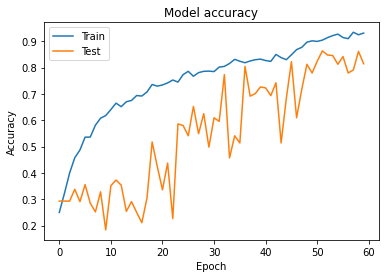

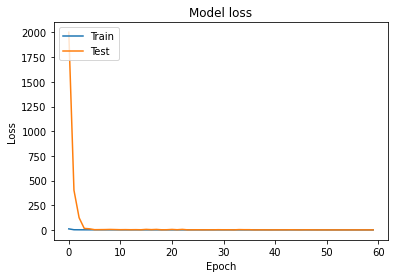

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

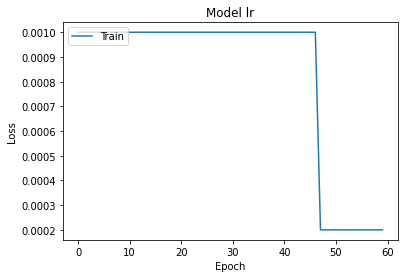

In [ ]:
plt.plot(history.history['lr'])
plt.title('Model lr')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'],loc='upper left')
plt.show()

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np
import glob

In [ ]:
model = load_model('model-resnet18.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
files = glob.glob('./test/*')
print(files)

['./test\\bike1.jpeg', './test\\bike2.jpeg', './test\\car1.jpeg', './test\\cat1.jpeg', './test\\dog1.jpeg', './test\\dog2.jpeg', './test\\dog3.jpeg', './test\\dog4.jpeg', './test\\ox1.jpeg']


In [ ]:
cls_list = ['bike', 'car', 'cats', 'doge', 'ox']

for f in files:
    img = image.load_img(f, target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = model.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('  {:.3f}  {}'.format(pred[i], cls_list[i]))

./test\bike1.jpeg
  0.999  bike
  0.001  car
  0.000  ox
  0.000  doge
  0.000  cats
./test\bike2.jpeg
  0.609  bike
  0.333  car
  0.050  ox
  0.008  cats
  0.000  doge
./test\car1.jpeg
  0.998  car
  0.002  bike
  0.000  ox
  0.000  cats
  0.000  doge
./test\cat1.jpeg
  0.999  cats
  0.001  ox
  0.000  doge
  0.000  car
  0.000  bike
./test\dog1.jpeg
  0.998  cats
  0.002  ox
  0.000  doge
  0.000  car
  0.000  bike
./test\dog2.jpeg
  0.950  ox
  0.031  doge
  0.018  cats
  0.001  car
  0.001  bike
./test\dog3.jpeg
  0.871  cats
  0.129  doge
  0.000  ox
  0.000  bike
  0.000  car
./test\dog4.jpeg
  0.998  doge
  0.001  cats
  0.001  bike
  0.000  ox
  0.000  car
./test\ox1.jpeg
  0.999  ox
  0.000  doge
  0.000  cats
  0.000  car
  0.000  bike
